In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_lncrna2target.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [5]:
import pickle
with open('moge/data/luad_data_multi_U-T.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network_val.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -5169
Total nodes (filtered): 27514
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -5950
Total nodes (filtered): 26733


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

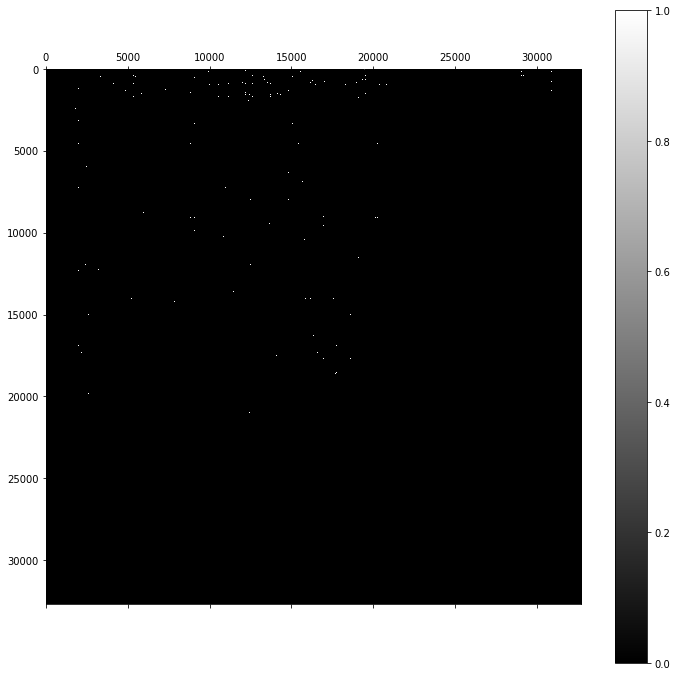

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

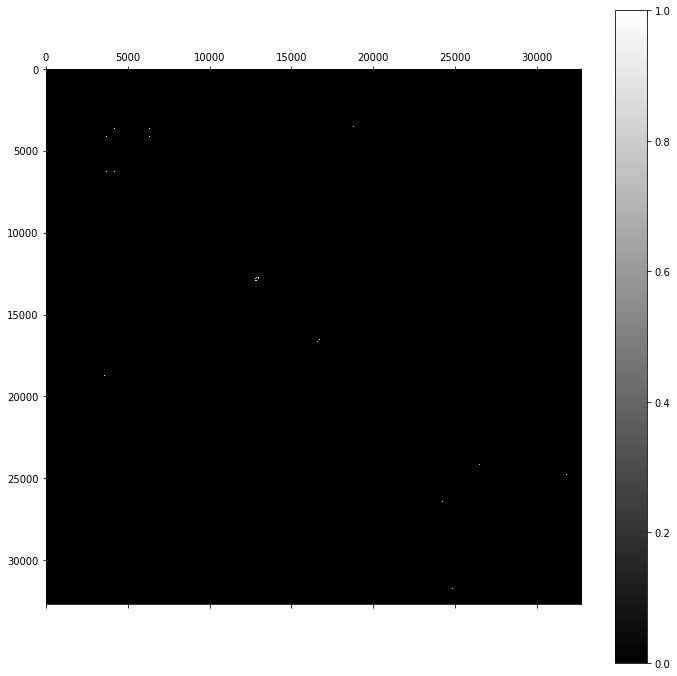

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

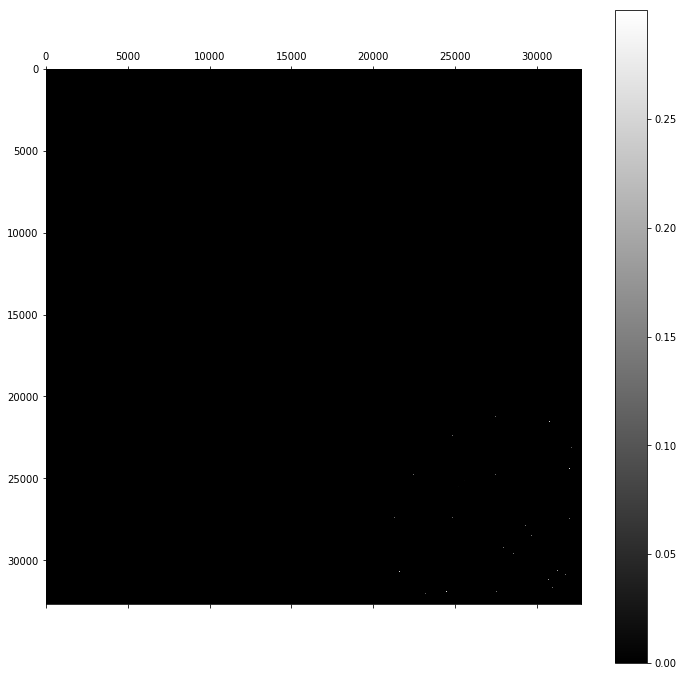

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

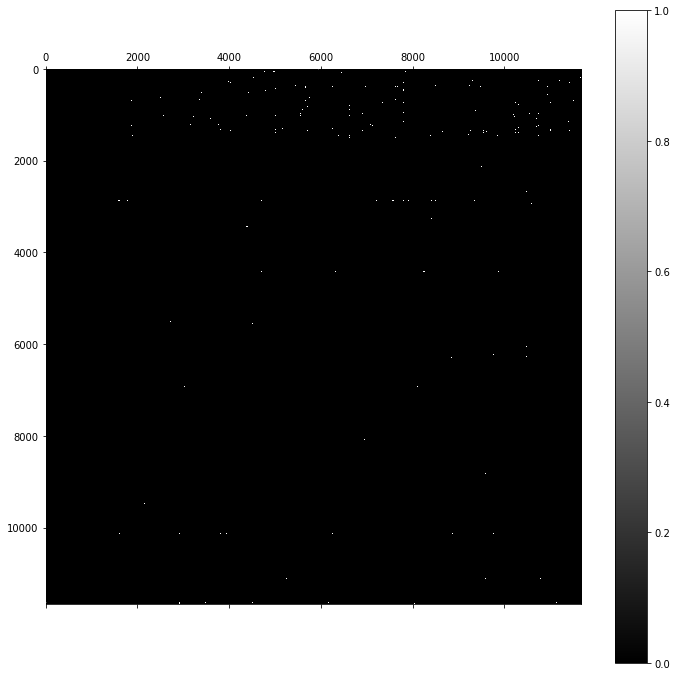

In [7]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [ ]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=128, batch_size=2048, lr=0.001, epochs=20, negative_sampling_ratio=2.0,
                                 max_length=2000, truncating="random", verbose=True)

Using TensorFlow backend.


In [ ]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, 
                        subsample=False, directed_proba=0.5, n_steps=2000, validation_steps=None, compression_func="log",
                        seed=2)

Ed_count: 583342 , Eu_count: 95126 , En_count: 444392
Ens_count: 1166684
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
Ed_count: 88412 , Eu_count: 0 , En_count: 0
Ens_count: 176824
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order 

# Visualize Embeddings

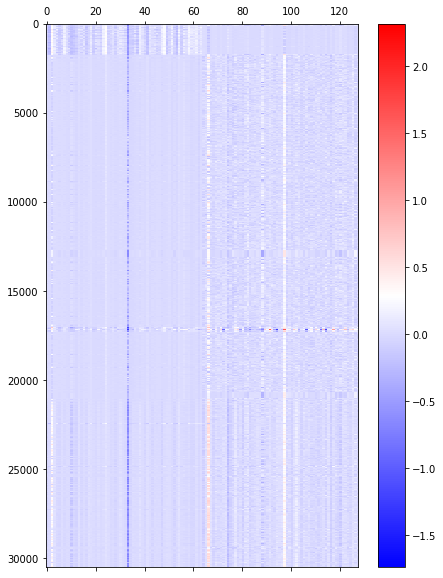

In [11]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

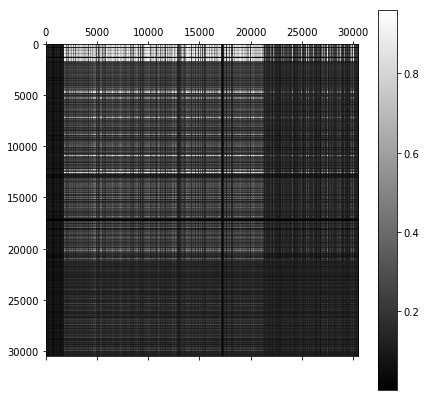

In [12]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list), figsize=(7,7))

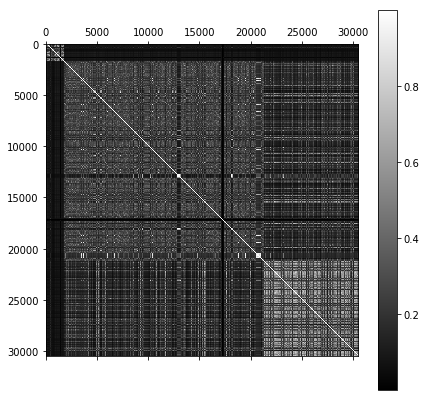

In [13]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u"), figsize=(7,7))

# Plot measures on training and testing

dict_keys(['val_loss', 'val_accuracy_d', 'val_precision_d', 'val_recall_d', 'val_auc_roc_d', 'loss', 'accuracy_d', 'precision_d', 'recall_d', 'auc_roc_d'])


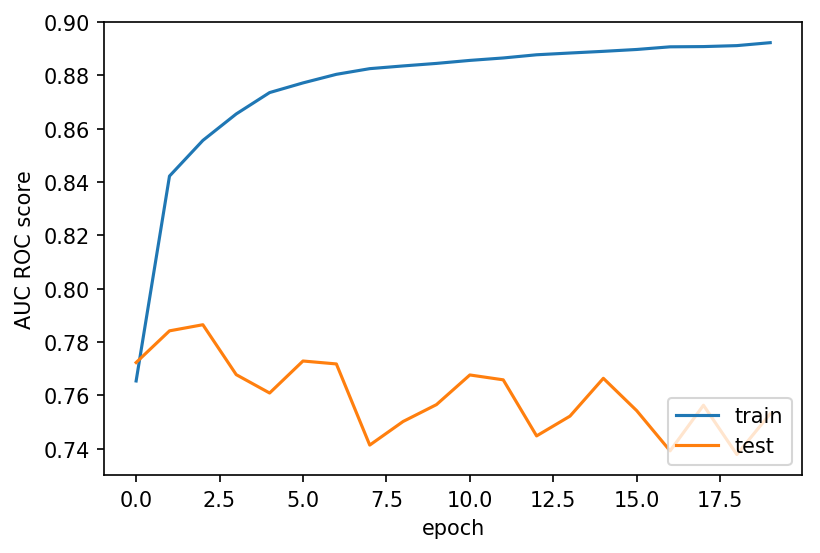

In [15]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=150)
plt.plot(history.history['accuracy_d'])
plt.plot(history.history['val_accuracy_d'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model & Embedding

In [16]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_128.randtrunc.multi_seq_UT.biogrid.full.euclidean.e20.model.h5")
# siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [37]:
siamese.siamese_net.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/Models/siamese_128.randtrunc.multi.full.l1_bce.e20.weights")

In [18]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.varlen.emb", 
                        variable_length=True, recompute=True, minlen=100)

# Import different models

In [6]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.varlen.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20411, 128)
LINE imported (20411, 128)
HOPE imported (20411, 128)
SDNE imported (20411, 128)
rna2rna imported (30502, 128)



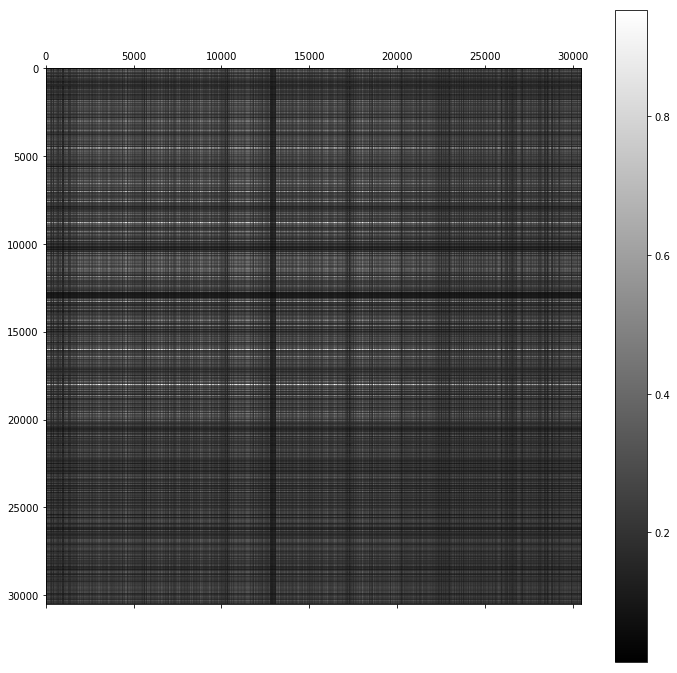

In [7]:
matrix_heatmap(rna2rna_emb.get_reconstructed_adj())

In [8]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [13]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=siamese.batch_size,
                             maxlen=2000,
                             truncating="post",
                             shuffle=True, seed=0)
generator_Ed.on_epoch_end()


Ed_count: 88412 , Eu_count: 0 , En_count: 0
Ens_count: 176824
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


In [14]:
X, y_true = generator_Ed.make_dataset()
y_true.shape
y_true = y_true.astype(int)
# y_true = (y_true > 0).astype(int)

In [15]:
y_pred_dict = {}
y_pred_dict["LINE"] = line_emb.predict(X)
y_pred_dict["HOPE"] = hope_emb.predict(X)
y_pred_dict["SDNE"] = sdne_emb.predict(X)
y_pred_dict["node2vec"] = node2vec_emb.predict(X)
y_pred_dict["rna2rna"] = rna2rna_emb.predict(X)
y_pred_dict["siamese"] = siamese.predict_generator(generator_Ed)

# Plot Precision-Recall Curve

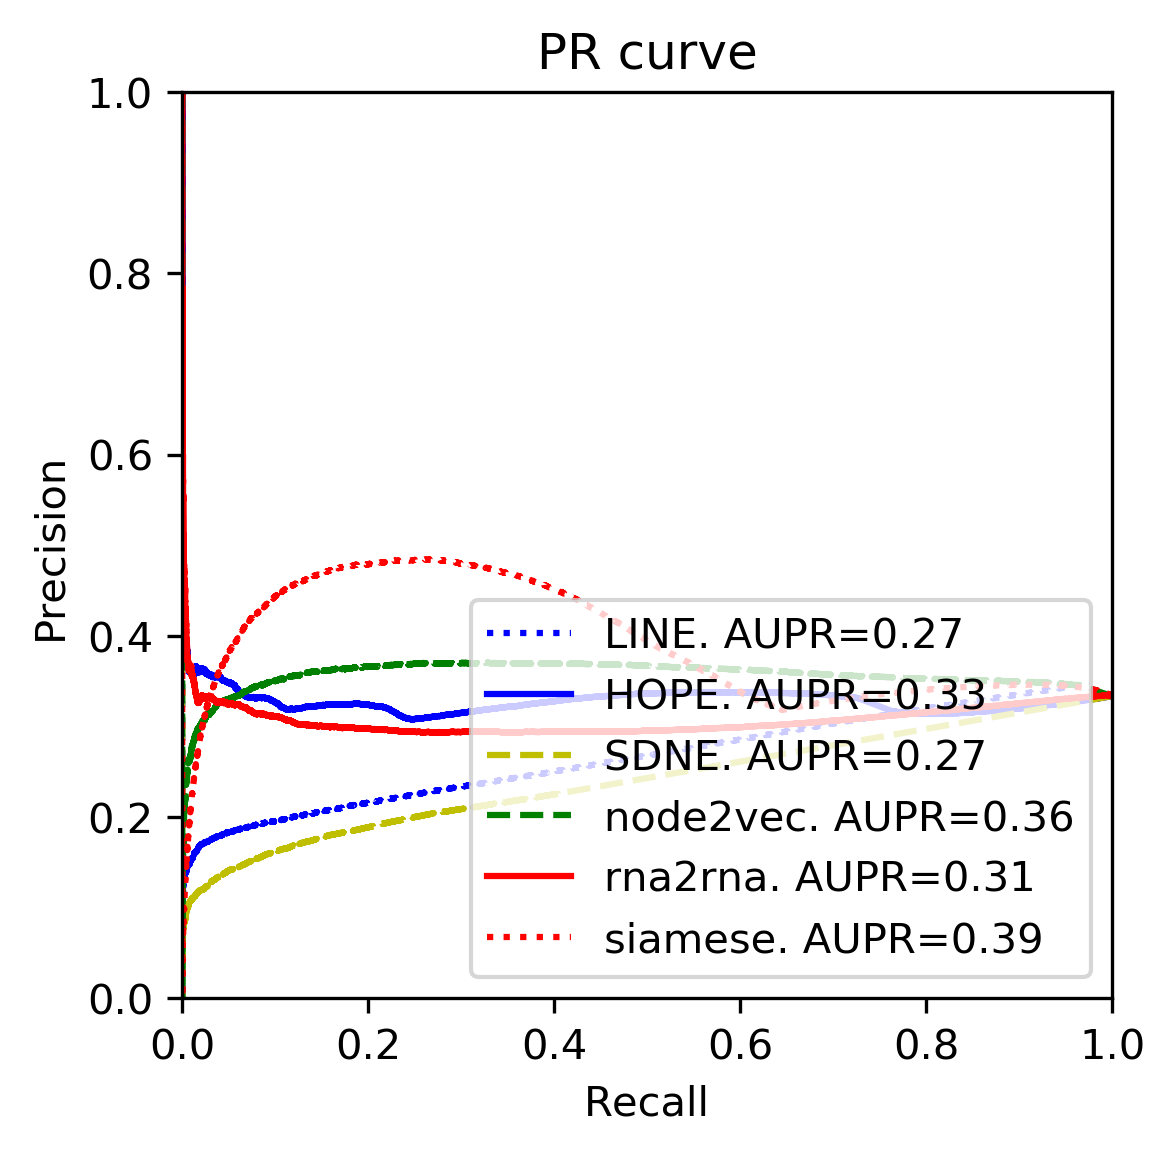

In [16]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score ,precision_recall_curve

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_dict = {"LINE":"b", "HOPE":"b", "SDNE":"y", "node2vec":"g", "rna2rna":"r", "siamese":"r"}
ls_dict = {"LINE":":", "HOPE":"-", "SDNE":"--", "node2vec":"--", "rna2rna":"-", "siamese":":"}

for method in y_pred_dict.keys():
    y_prob_pred = y_pred_dict[method]
    average_precision = average_precision_score(y_true=y_true, y_score=y_prob_pred)
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

    ax.plot(recall, precision, color=color_dict[method], ls=ls_dict[method],
             label=method+'. AUPR={0:0.2f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('PR curve')
plt.show()

Method: node2vec
Method: LINE
Method: HOPE
Method: SDNE
Method: rna2rna
Method: siamese


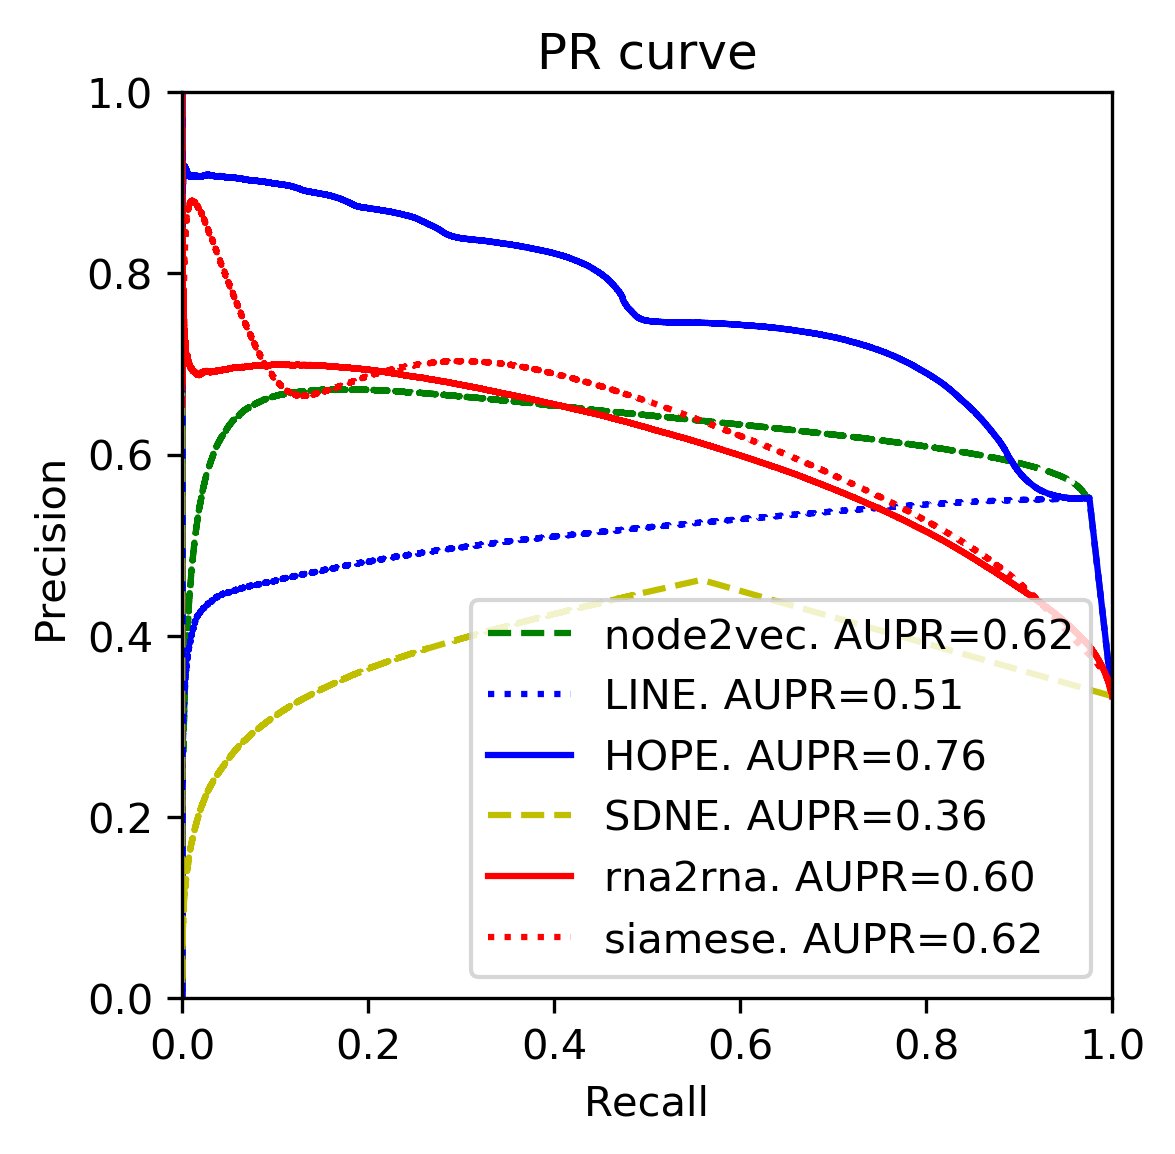

In [18]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred
evaluate_pr_curve_link_pred(methods, X, y_true)

# Top-K Link Prediction

In [78]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=100))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE


KeyboardInterrupt: 

In [49]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.48106973447745943, 'completeness': 0.5307421591251636, 'nmi': 0.5046866738386284}
LINE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.49492701765898045, 'completeness': 0.5367213865526316, 'nmi': 0.5149776107360682}
HOPE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.39215164258602164, 'completeness': 0.4987670443849902, 'nmi': 0.43908006102853947}
SDNE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3611903955255135, 'completeness': 0.47779308835238854, 'nmi': 0.4113889674292342}
rna2rna
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.45017389042765477, 'completeness': 0.5024469324909046, 'nmi': 0.4748762254427622}
siamese
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.4714759983300483, 'completeness': 0.5146687386335228, 'nmi': 0.4921264562110028}


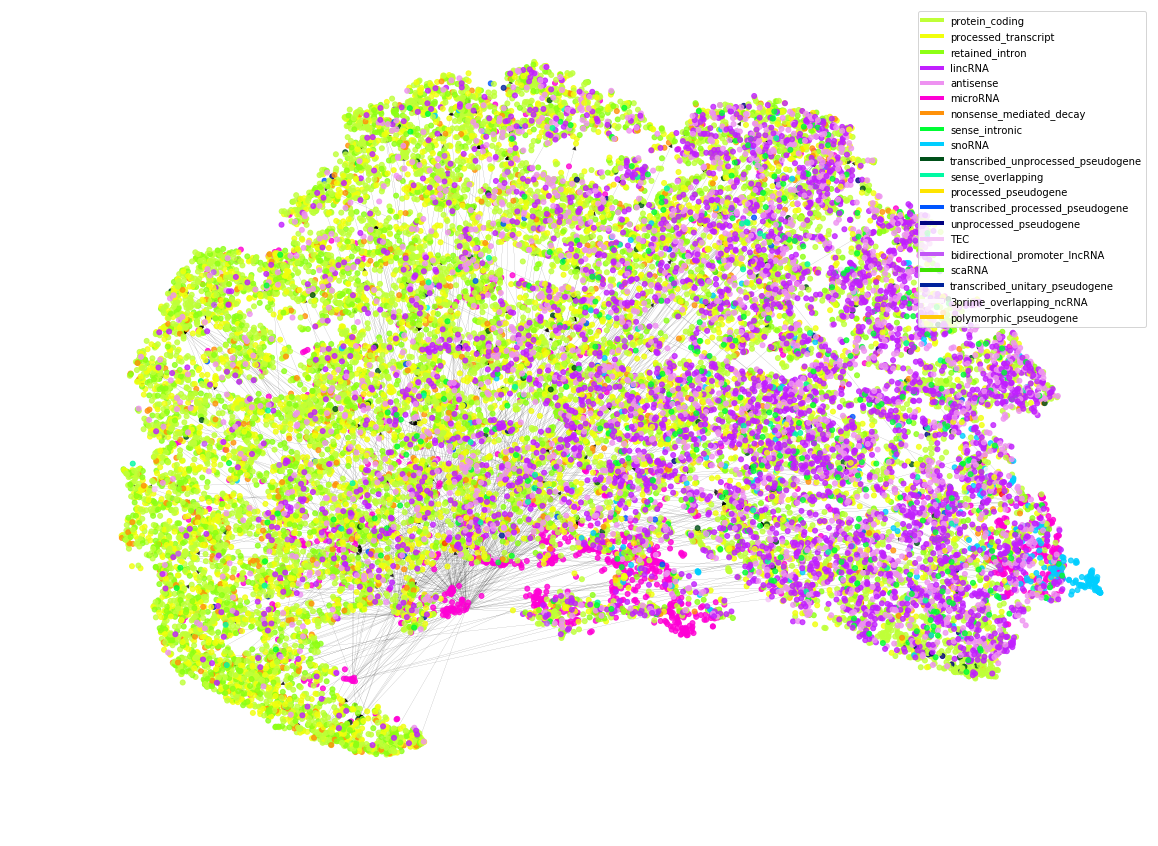

In [33]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(rna2rna_emb, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network.node_list, edge_types=["d"])[:500],
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [51]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Family", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 567 , # of nodes to train/test: 10233


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 56.45618047714233), ('score_time', 0.10034103393554687), ('test_precision_macro', 0.024075103264725783), ('test_recall_macro', 0.045950470611357486), ('test_f1_macro', 0.02900506344887067)]

LINE
# of labels with >cv samples: 567 , # of nodes to train/test: 10233


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 95.88275322914123), ('score_time', 0.09379763603210449), ('test_precision_macro', 0.02925769114659372), ('test_recall_macro', 0.03400704316004048), ('test_f1_macro', 0.030213255427727376)]

HOPE
# of labels with >cv samples: 567 , # of nodes to train/test: 10233


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 430.31133499145506), ('score_time', 0.08355593681335449), ('test_precision_macro', 0.010957112545887451), ('test_recall_macro', 0.015233660311496793), ('test_f1_macro', 0.011406723268294259)]

SDNE
# of labels with >cv samples: 567 , # of nodes to train/test: 10233


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 261.54238748550415), ('score_time', 0.07221956253051758), ('test_precision_macro', 0.003351584198991374), ('test_recall_macro', 0.0035462698671371072), ('test_f1_macro', 0.0018965935762058112)]

rna2rna
# of labels with >cv samples: 567 , # of nodes to train/test: 11502


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 690.3207640171051), ('score_time', 0.08966274261474609), ('test_precision_macro', 0.0054054234269919395), ('test_recall_macro', 0.006901292164021989), ('test_f1_macro', 0.004132866739786749)]

siamese
# of labels with >cv samples: 567 , # of nodes to train/test: 11502


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 92.50678095817565), ('score_time', 0.07683091163635254), ('test_precision_macro', 0.005761809164060215), ('test_recall_macro', 0.012441307007293661), ('test_f1_macro', 0.006637109483309414)]


In [52]:
for method in methods.keys():
    print("\n", method)
    for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
        print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 node2vec


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:14: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(adj_list, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:15: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(adj_list, k_power)))


MIR LNC 0.023521782134753904
LNC MIR 0.30764955020587587
LNC GE 0.025937457777507795
MIR GE 0.0718119685642557
GE GE 0.005460576065079376

 LINE
MIR LNC 0.8870346289276513
LNC MIR 0.8870265884054033
LNC GE 0.5821123896235464
MIR GE 0.8925477274169321
GE GE 0.5719009702788508

 HOPE
MIR LNC 0.39892042683835294
LNC MIR 0.39864469698569327
LNC GE 0.7801205927495763
MIR GE 0.5674137967845859
GE GE 0.7732608201963327

 SDNE
MIR LNC 5.5436094514923614e-05
LNC MIR 5.5434109032688793e-05
LNC GE 0.013401023990723803
MIR GE 5.925582469802795e-05
GE GE 0.003050202016328385

 rna2rna
MIR LNC 3.1403735389620764e-05
LNC MIR 0.00015794676033143267
LNC GE 9.156519451008619e-07
MIR GE 1.9037275527899237e-05
GE GE 9.43142368008448e-07

 siamese
MIR LNC 0.29099119665625484
LNC MIR 0.10453936309388769
LNC GE 0.09056326922825297
MIR GE 0.11171542690795859
GE GE 0.09827071370637804


# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>